# Triple Stratified KFold CV with TFRecords
This is a simple starter notebook for Kaggle's Melanoma Comp showing triple stratifed KFold with TFRecords. Triple stratified KFold is explained [here][2]. There are many configuration variables below to allow you to experiment. Use either GPU or TPU. You can control which size images are loaded, which efficientNets are used, and whether external data is used. You can experiment with different data augmentation, model architecture, loss, optimizers, and learning schedules. The TFRecords contain meta data, so you can input that into your CNN too. 

**NOTE:** this notebook lets you run a different experiment in each fold if you want to run lots of experiments. (Then it is like running multiple holdout validaiton experiments but in that case note that the overall CV score is meaningless because LB will be much higher when the multiple experiments are ensembled to predict test). **If you want a proper CV with a reliable overall CV score you need to choose the same configuration for each fold.**

This notebook follows the 5 step process presented in my "How to compete with GPUs Workshop" [here][1]. Some code sections have been reused from AgentAuers' great notebook [here][3]

[1]: https://www.kaggle.com/cdeotte/how-to-compete-with-gpus-workshop
[2]: https://www.kaggle.com/c/siim-isic-melanoma-classification/discussion/165526
[3]: https://www.kaggle.com/agentauers/incredible-tpus-finetune-effnetb0-b6-at-once

# Kaggle's SIIM-ISIC Melanoma Classification
In this competition, we need to identify melanoma in images of skin lesions. Full description [here][1]. This is a very challenging image classification task as seen by looking at the sample images below. Can you recognize the differences between images? Below are example of skin images with and without melanoma.

[1]: https://www.kaggle.com/c/siim-isic-melanoma-classification

# Initialize Environment

In [1]:
!pip install -q efficientnet >> /dev/null

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import pandas as pd, numpy as np
from kaggle_datasets import KaggleDatasets
import tensorflow as tf, re, math
import tensorflow.keras.backend as K
import efficientnet.tfkeras as efn
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.losses import binary_crossentropy

## Configuration
In order to be a proper cross validation with a meaningful overall CV score (aligned with LB score), **you need to choose the same** `IMG_SIZES`, `INC2019`, `INC2018`, and `EFF_NETS` **for each fold**. If your goal is to just run lots of experiments, then you can choose to have a different experiment in each fold. Then each fold is like a holdout validation experiment. When you find a configuration you like, you can use that configuration for all folds. 
* DEVICE - is GPU or TPU
* SEED - a different seed produces a different triple stratified kfold split.
* FOLDS - number of folds. Best set to 3, 5, or 15 but can be any number between 2 and 15
* IMG_SIZES - is a Python list of length FOLDS. These are the image sizes to use each fold
* INC2019 - This includes the new half of the 2019 competition data. The second half of the 2019 data is the comp data from 2018 plus 2017
* INC2018 - This includes the second half of the 2019 competition data which is the comp data from 2018 plus 2017
* BATCH_SIZES - is a list of length FOLDS. These are batch sizes for each fold. For maximum speed, it is best to use the largest batch size your GPU or TPU allows.
* EPOCHS - is a list of length FOLDS. These are maximum epochs. Note that each fold, the best epoch model is saved and used. So if epochs is too large, it won't matter.
* EFF_NETS - is a list of length FOLDS. These are the EfficientNets to use each fold. The number refers to the B. So a number of `0` refers to EfficientNetB0, and `1` refers to EfficientNetB1, etc.
* WGTS - this should be `1/FOLDS` for each fold. This is the weight when ensembling the folds to predict the test set. If you want a weird ensemble, you can use different weights.
* TTA - test time augmentation. Each test image is randomly augmented and predicted TTA times and the average prediction is used. TTA is also applied to OOF during validation.

In [3]:
DEVICE = "TPU" #or "TPU"

# USE DIFFERENT SEED FOR DIFFERENT STRATIFIED KFOLD
SEED = 42; FOLDS = 5

# WHICH FOLD TO PERFORM EXPERIMENTS ON
FNUMBER = 2; EXPERIMENTS = 1

# WHICH IMAGE SIZES TO LOAD EACH FOLD
# CHOOSE 128, 192, 256, 384, 512, 768 
IMG_SIZES = [128]*EXPERIMENTS

# INCLUDE OLD COMP DATA? YES=1 NO=0
INC2019 = [0]*EXPERIMENTS
INC2018 = [1]*EXPERIMENTS

# UPSAMPLE MALIGNANT COUNT TIMES
M1 = [24]*EXPERIMENTS #2020 malig
M2 = [1]*EXPERIMENTS #ISIC malig
M3 = [1]*EXPERIMENTS #2019 good malig
M4 = [1]*EXPERIMENTS #2018 2017 malig

#CLASS WEIGHTS FOR EXPERIMENTS
CW = [None]*EXPERIMENTS
no_s = 32692
for i in range(EXPERIMENTS):
    mal_add = 581*M1[i]+580*M2[i]+1185*M3[i]+1614*M4[i]
    weight_for_0 = (1 / (no_s-(581+mal_add)))*(no_s+mal_add)/2.0 
    weight_for_1 = (1 / (581+mal_add))*(no_s+mal_add)/2.0
    CW[i] = [weight_for_0,weight_for_1]
print(CW)    
    
# COARSE DROPOUT
DROP_FREQ = [0.7] # between 0 and 1
DROP_CT = [7] # may slow training if CT>16
DROP_SIZE = [0.14] # between 0 and 1

# BATCH SIZE AND EPOCHS
BATCH_SIZES = [4]*EXPERIMENTS
EPOCHS = [15]*EXPERIMENTS

# WHICH EFFICIENTNET B? TO USE
EFF_NETS = [6]*EXPERIMENTS

# WEIGHTS FOR FOLD MODELS WHEN PREDICTING TEST
WGTS = [1/EXPERIMENTS]*EXPERIMENTS

# TEST TIME AUGMENTATION STEPS
TTA = 11
INFER_TEST = True

[[1.6910670814173654, 1.3967549151027703]]


PATHS

In [4]:
################ DELETE IF USING COLAB PRO################
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
user_credential = user_secrets.get_gcloud_credential()
user_secrets.set_tensorflow_credential(user_credential)
from kaggle_datasets import KaggleDatasets
##########################################################

In [5]:
#display aug


GCS_DS_PATH_tr_h = KaggleDatasets().get_gcs_path('melanoma-hairs')


# GCS_PATH = [None]*FOLDS; GCS_PATH2 = [None]*FOLDS
# for i,k in enumerate(IMG_SIZES):
#     GCS_PATH[i] = KaggleDatasets().get_gcs_path('melanoma-%ix%i'%(k,k))
#     GCS_PATH2[i] = KaggleDatasets().get_gcs_path('isic2019-%ix%i'%(k,k))
# # files_train = np.sort(np.array(tf.io.gfile.glob(GCS_PATH[0] + '/train*.tfrec')))
# files_test  = np.sort(np.array(tf.io.gfile.glob(GCS_PATH[0] + '/test*.tfrec')))

PATH9 =  '../input/jpeg-melanoma-128x128/train/' #change with jpeg path, keep it 128..



################ DELETE IF USING COLAB PRO################
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
user_credential = user_secrets.get_gcloud_credential()
user_secrets.set_tensorflow_credential(user_credential)
from kaggle_datasets import KaggleDatasets
##########################################################
GCS_DS_PATH_tr = KaggleDatasets().get_gcs_path('freshstart128') #TRAIN PATH..ISIC20F
files_trains = tf.io.gfile.glob(GCS_DS_PATH_tr + '/isic20F*.tfrec') # train path

In [6]:
skf = KFold(n_splits=FOLDS,shuffle=True,random_state=SEED)
for fold,(idxT,idxV) in enumerate(skf.split(np.arange(15))):
    if fold==(FNUMBER-1):
        idxTT = idxT; idxVV = idxV
        print('### Using fold',fold,'for experiments')
    print('Fold',fold,'has TRAIN:',idxT,'VALID:',idxV)

Fold 0 has TRAIN: [ 1  2  3  4  5  6  7  8 10 12 13 14] VALID: [ 0  9 11]
### Using fold 1 for experiments
Fold 1 has TRAIN: [ 0  1  2  3  4  6  7  9 10 11 12 14] VALID: [ 5  8 13]
Fold 2 has TRAIN: [ 0  3  4  5  6  7  8  9 10 11 12 13] VALID: [ 1  2 14]
Fold 3 has TRAIN: [ 0  1  2  3  5  6  8  9 11 12 13 14] VALID: [ 4  7 10]
Fold 4 has TRAIN: [ 0  1  2  4  5  7  8  9 10 11 13 14] VALID: [ 3  6 12]


In [7]:
if DEVICE == "TPU":
    print("connecting to TPU...")
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print('Running on TPU ', tpu.master())
    except ValueError:
        print("Could not connect to TPU")
        tpu = None

    if tpu:
        try:
            print("initializing  TPU ...")
            tf.config.experimental_connect_to_cluster(tpu)
            tf.tpu.experimental.initialize_tpu_system(tpu)
            strategy = tf.distribute.experimental.TPUStrategy(tpu)
            print("TPU initialized")
        except _:
            print("failed to initialize TPU")
    else:
        DEVICE = "GPU"

if DEVICE != "TPU":
    print("Using default strategy for CPU and single GPU")
    strategy = tf.distribute.get_strategy()

if DEVICE == "GPU":
    print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
    

AUTO     = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')

connecting to TPU...
Running on TPU  grpc://10.0.0.2:8470
initializing  TPU ...
TPU initialized
REPLICAS: 8


# Step 1: Preprocess
Preprocess has already been done and saved to TFRecords. Here we choose which size to load. We can use either 128x128, 192x192, 256x256, 384x384, 512x512, 768x768 by changing the `IMG_SIZES` variable in the preceeding code section. These TFRecords are discussed [here][1]. The advantage of using different input sizes is discussed [here][2]

[1]: https://www.kaggle.com/c/siim-isic-melanoma-classification/discussion/155579
[2]: https://www.kaggle.com/c/siim-isic-melanoma-classification/discussion/160147

# Step 2: Data Augmentation
This notebook uses rotation, sheer, zoom, shift augmentation first shown in this notebook [here][1] and successfully used in Melanoma comp by AgentAuers [here][2]. This notebook also uses horizontal flip, hue, saturation, contrast, brightness augmentation similar to last years winner and also similar to AgentAuers' notebook.

Additionally we can decide to use external data by changing the variables `INC2019` and `INC2018` in the preceeding code section. These variables respectively indicate whether to load last year 2019 data and/or year 2018 + 2017 data. These datasets are discussed [here][3]

Consider experimenting with different augmenation and/or external data. The code to load TFRecords is taken from AgentAuers' notebook [here][2]. Thank you AgentAuers, this is great work.

[1]: https://www.kaggle.com/cdeotte/rotation-augmentation-gpu-tpu-0-96
[2]: https://www.kaggle.com/agentauers/incredible-tpus-finetune-effnetb0-b6-at-once
[3]: https://www.kaggle.com/c/siim-isic-melanoma-classification/discussion/164910

In [8]:
ROT_ = 180.0
SHR_ = 2.0
HZOOM_ = 8.0
WZOOM_ = 8.0
HSHIFT_ = 8.0
WSHIFT_ = 8.0

In [9]:
def get_mat(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    # returns 3x3 transformmatrix which transforms indicies
        
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    shear    = math.pi * shear    / 180.

    def get_3x3_mat(lst):
        return tf.reshape(tf.concat([lst],axis=0), [3,3])
    
    # ROTATION MATRIX
    c1   = tf.math.cos(rotation)
    s1   = tf.math.sin(rotation)
    one  = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    
    rotation_matrix = get_3x3_mat([c1,   s1,   zero, 
                                   -s1,  c1,   zero, 
                                   zero, zero, one])    
    # SHEAR MATRIX
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)    
    
    shear_matrix = get_3x3_mat([one,  s2,   zero, 
                                zero, c2,   zero, 
                                zero, zero, one])        
    # ZOOM MATRIX
    zoom_matrix = get_3x3_mat([one/height_zoom, zero,           zero, 
                               zero,            one/width_zoom, zero, 
                               zero,            zero,           one])    
    # SHIFT MATRIX
    shift_matrix = get_3x3_mat([one,  zero, height_shift, 
                                zero, one,  width_shift, 
                                zero, zero, one])
    
    return K.dot(K.dot(rotation_matrix, shear_matrix), 
                 K.dot(zoom_matrix,     shift_matrix))


def transform(image, DIM=256):    
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated, sheared, zoomed, and shifted
    XDIM = DIM%2 #fix for size 331
    
    rot = ROT_ * tf.random.normal([1], dtype='float32')
    shr = SHR_ * tf.random.normal([1], dtype='float32') 
    h_zoom = 1.0 + tf.random.normal([1], dtype='float32') / HZOOM_
    w_zoom = 1.0 + tf.random.normal([1], dtype='float32') / WZOOM_
    h_shift = HSHIFT_ * tf.random.normal([1], dtype='float32') 
    w_shift = WSHIFT_ * tf.random.normal([1], dtype='float32') 

    # GET TRANSFORMATION MATRIX
    m = get_mat(rot,shr,h_zoom,w_zoom,h_shift,w_shift) 

    # LIST DESTINATION PIXEL INDICES
    x   = tf.repeat(tf.range(DIM//2, -DIM//2,-1), DIM)
    y   = tf.tile(tf.range(-DIM//2, DIM//2), [DIM])
    z   = tf.ones([DIM*DIM], dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(m, tf.cast(idx, dtype='float32'))
    idx2 = K.cast(idx2, dtype='int32')
    idx2 = K.clip(idx2, -DIM//2+XDIM+1, DIM//2)
    
    # FIND ORIGIN PIXEL VALUES           
    idx3 = tf.stack([DIM//2-idx2[0,], DIM//2-1+idx2[1,]])
    d    = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM, DIM,3])

**Hair Augmentation**

In [10]:
n_max=6     # the maximum number of hairs to augment
im_size=IMG_SIZES[0]  # all images are resized to this size

hair_images = tf.io.gfile.glob([GCS_DS_PATH_tr_h+'/' +str(x)+'.png' for x in [1,2,4,5]])
hair_images_tf = tf.convert_to_tensor(hair_images)


def hair_aug_tf(input_img):
    if tf.random.uniform(shape=[],minval=0)>=0.7:
        scale=tf.cast(im_size/256, dtype=tf.float32)
    #     tf.random.set_seed(42)
        # Copy the input image, so it won't be changed
        img=tf.identity(input_img) 



        # Randomly choose the number of hairs to augment (up to n_max)
        n_hairs = tf.random.uniform(shape=[],minval=2, maxval=tf.constant(n_max)+1, dtype=tf.int32)

        im_height = tf.shape(img)[0]
        im_width = tf.shape(img)[1]

        if n_hairs == 0:
#             print('ss')
            return img

        for _ in tf.range(n_hairs):
#             print('ss')
            # Read a random hair image
            i=tf.random.uniform(shape=[], maxval=tf.shape(hair_images_tf)[0], 
                                dtype=tf.int32)
            fname=hair_images_tf[i]

            bits = tf.io.read_file(fname)
            hair = tf.image.decode_jpeg(bits)


    #         hair = tf.reverse(hair, -1)
            # Rescale the hair image to the right size (256 -- original size)
    #         hair = hairs[i]
            new_width=tf.cast(scale*tf.cast(tf.shape(hair)[1], dtype=tf.float32), dtype=tf.int32)
            new_height=tf.cast(scale*tf.cast(tf.shape(hair)[0], dtype=tf.float32), dtype=tf.int32)
            hair = tf.image.resize(hair, [new_height, new_width])


            # Random flips of the hair image
            hair = tf.image.random_flip_left_right(hair)
            hair = tf.image.random_flip_up_down(hair)
            # Random number of 90 degree rotations
            n_rot=tf.random.uniform(shape=[], maxval=4,
                                    dtype=tf.int32)
            hair = tf.image.rot90(hair, k=n_rot)

            h_height = tf.shape(hair)[0]
            h_width = tf.shape(hair)[1]

            roi_h0 = tf.random.uniform(shape=[], maxval=im_height - h_height + 1, 
                                        dtype=tf.int32)
            roi_w0 = tf.random.uniform(shape=[], maxval=im_width - h_width + 1, 
                                        dtype=tf.int32)


            roi = img[roi_h0:(roi_h0 + h_height), roi_w0:(roi_w0 + h_width)]  

            # Convert the hair image to grayscale 
            # (slice to remove the trainsparency channel)
            hair2gray = tf.image.rgb_to_grayscale(hair[:, :, :3])
    #         hair2gray = 255-tf.image.rgb_to_grayscale(hair[:, :, :3])
    #         hair2gray = tf.reverse(tf.image.rgb_to_grayscale(hair[:, :, :3]),-1)
            mask=hair2gray>10


            img_bg = tf.multiply(roi, tf.cast(tf.image.grayscale_to_rgb(~mask),
                                              dtype=tf.float32))
            hair_fg = tf.multiply(tf.cast(1- hair[:, :, :3], dtype=tf.int32),
                                  tf.cast(tf.image.grayscale_to_rgb(mask), dtype=tf.int32)#uint8)
                                 )
    #         hair_fg = tf.multiply(1-tf.cast(hair[:, :, :3], dtype=tf.int32),
    #                               tf.cast(mask, dtype=tf.int32)#uint8)
    #                              )

    #         dst = tf.add(img_bg, tf.cast(255 - hair_fg, dtype=tf.float32))
            dst = tf.add(img_bg, tf.cast(hair_fg, dtype=tf.float32))
    #         dst = tf.bitwise.invert(dst)
            paddings = tf.stack([
                [roi_h0, im_height-(roi_h0 + h_height)], 
                [roi_w0, im_width-(roi_w0 + h_width)],
                [0, 0]
            ])

            # Pad dst with zeros to make it the same shape as image.
            dst_padded=tf.pad(dst, paddings, "CONSTANT")
            # Create a boolean mask with zeros at the pixels of
            # the augmentation segment and ones everywhere else
            mask_img=tf.pad(tf.ones_like(dst), paddings, "CONSTANT")
            mask_img=~tf.cast(mask_img, dtype=tf.bool)
            # Make a hole in the original image at the location
            # of the augmentation segment
            img_hole=tf.multiply(img, tf.cast(mask_img, dtype=tf.float32))
            # Inserting the augmentation segment in place of the hole
            img=tf.add(img_hole, dst_padded)
        return img
    else:
        return input_img

dropout

In [11]:
def dropout(image, DIM=256, PROBABILITY = 0.75, CT = 8, SZ = 0.2):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image with CT squares of side size SZ*DIM removed
    
    # DO DROPOUT WITH PROBABILITY DEFINED ABOVE
    P = tf.cast( tf.random.uniform([],0,1)<PROBABILITY, tf.int32)
    if (P==0)|(CT==0)|(SZ==0): return image
    
    for k in range(CT):
        # CHOOSE RANDOM LOCATION
        x = tf.cast( tf.random.uniform([],0,DIM),tf.int32)
        y = tf.cast( tf.random.uniform([],0,DIM),tf.int32)
        # COMPUTE SQUARE 
        WIDTH = tf.cast( SZ*DIM,tf.int32) * P
        ya = tf.math.maximum(0,y-WIDTH//2)
        yb = tf.math.minimum(DIM,y+WIDTH//2)
        xa = tf.math.maximum(0,x-WIDTH//2)
        xb = tf.math.minimum(DIM,x+WIDTH//2)
        # DROPOUT IMAGE
        one = image[ya:yb,0:xa,:]
        two = tf.zeros([yb-ya,xb-xa,3]) 
        three = image[ya:yb,xb:DIM,:]
        middle = tf.concat([one,two,three],axis=1)
        image = tf.concat([image[0:ya,:,:],middle,image[yb:DIM,:,:]],axis=0)
            
    # RESHAPE HACK SO TPU COMPILER KNOWS SHAPE OF OUTPUT TENSOR 
    image = tf.reshape(image,[DIM,DIM,3])
    return image

In [12]:
def read_labeled_tfrecord(example):
    tfrec_format = {
        'image'                        : tf.io.FixedLenFeature([], tf.string),
        'image_name'                   : tf.io.FixedLenFeature([], tf.string),
        'patient_id'                   : tf.io.FixedLenFeature([], tf.int64),
        'sex'                          : tf.io.FixedLenFeature([], tf.int64),
        'age_approx'                   : tf.io.FixedLenFeature([], tf.float32),
        'anatom_site_general_challenge': tf.io.FixedLenFeature([], tf.int64),
        'target'                       : tf.io.FixedLenFeature([], tf.float32),
        'diagnosis'                    : tf.io.FixedLenFeature([], tf.int64),
        'width'                        : tf.io.FixedLenFeature([], tf.float32),
        'height'                       : tf.io.FixedLenFeature([], tf.float32),
#         'dist_test'                    : tf.io.FixedLenFeature([], tf.float32),
        'cluster'                      : tf.io.FixedLenFeature([], tf.int64)
    }           
    example = tf.io.parse_single_example(example, tfrec_format)
    data = {}
#     data['age_approx'] = tf.cast(example['age_approx'], tf.int32)
#     data['sex'] = tf.cast(example['sex'], tf.int32)
#     data['anatom_site_general_challenge'] = tf.cast(tf.one_hot(example['anatom_site_general_challenge'], 7), tf.int32)
    data['cluster'] = tf.cast(tf.one_hot(example['cluster'], 25), tf.int64)
#     diag = tf.cast(tf.one_hot(example['diagnosis'], 17), tf.int64)
    return example['image'], example['target'], data


def read_unlabeled_tfrecord(example, return_image_name=True):
    tfrec_format = {
        'image'                        : tf.io.FixedLenFeature([], tf.string),
        'image_name'                   : tf.io.FixedLenFeature([], tf.string),
#         'patient_id'                   : tf.io.FixedLenFeature([], tf.int64),
        'sex'                          : tf.io.FixedLenFeature([], tf.int64),
        'age_approx'                   : tf.io.FixedLenFeature([], tf.float32),
        'anatom_site_general_challenge': tf.io.FixedLenFeature([], tf.int64),
        'target'                       : tf.io.FixedLenFeature([], tf.float32),
#         'diagnosis'                    : tf.io.FixedLenFeature([], tf.int64),
#         'width'                        : tf.io.FixedLenFeature([], tf.float32),
#         'height'                       : tf.io.FixedLenFeature([], tf.float32),
#         'dist_test'                    : tf.io.FixedLenFeature([], tf.float32),
        'cluster'                      : tf.io.FixedLenFeature([], tf.int64)
    } 
    example = tf.io.parse_single_example(example, tfrec_format)
    data = {}
#     data['age_approx'] = tf.cast(example['age_approx'], tf.int32)
#     data['sex'] = tf.cast(example['sex'], tf.int32)
#     data['anatom_site_general_challenge'] = tf.cast(tf.one_hot(example['anatom_site_general_challenge'], 7), tf.int32)
    data['cluster'] = tf.cast(tf.one_hot(example['cluster'], 25), tf.int64)
    
    return example['image'], example['image_name'] if return_image_name else 0, data

 
def prepare_image(img, augment=True, dim=256, droprate=0, dropct=0, dropsize=0):    
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.cast(img, tf.float32) / 255.0
    
    if augment:
        img = transform(img,DIM=dim)
        if (droprate!=0)&(dropct!=0)&(dropsize!=0): 
            img = dropout(img, DIM=dim, PROBABILITY=droprate, CT=dropct, SZ=dropsize)
        img = tf.image.random_flip_left_right(img)
        #img = tf.image.random_hue(img, 0.01)
        img = tf.image.random_saturation(img, 0.7, 1.3)
        img = tf.image.random_contrast(img, 0.8, 1.2)
        img = tf.image.random_brightness(img, 0.1)
                      
    img = tf.reshape(img, [dim,dim, 3])
            
    return img

def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) 
         for filename in filenames]
    return np.sum(n)

In [13]:
# function for training and validation dataset
def setup_input1(image, label, data):
    
    # get anatom site general challenge vectors
#     anatom = [tf.cast(data['anatom_site_general_challenge'][i], dtype = tf.float32) for i in range(7)]
    cluster = [tf.cast(data['cluster'][i], dtype = tf.float32) for i in range(25)]
#     tab_data = [tf.cast(data[tfeat], dtype = tf.float32) for tfeat in ['age_approx', 'sex']]
    tab_data = [tf.cast(data[tfeat], dtype = tf.float32) for tfeat in []]
    
    tabular = tf.stack(tab_data + cluster)
    
    return {'inp1': image, 'inp2':  tabular}, label

# function for the test set
def setup_input2(image, image_name, data):
    
    # get anatom site general challenge vectors
#     anatom = [tf.cast(data['anatom_site_general_challenge'][i], dtype = tf.float32) for i in range(7)]
    cluster = [tf.cast(data['cluster'][i], dtype = tf.float32) for i in range(25)]
#     tab_data = [tf.cast(data[tfeat], dtype = tf.float32) for tfeat in ['age_approx', 'sex']]
    tab_data = [tf.cast(data[tfeat], dtype = tf.float32) for tfeat in []]
    
    tabular = tf.stack(tab_data + cluster)
    
    return {'inp1': image, 'inp2':  tabular}, image_name

# function for the validation (image name)
def setup_input3(image, image_name, target, data):
    
    # get anatom site general challenge vectors
#     anatom = [tf.cast(data['anatom_site_general_challenge'][i], dtype = tf.float32) for i in range(7)]
    cluster = [tf.cast(data['cluster'][i], dtype = tf.float32) for i in range(25)]
#     tab_data = [tf.cast(data[tfeat], dtype = tf.float32) for tfeat in ['age_approx', 'sex']]
    tab_data = [tf.cast(data[tfeat], dtype = tf.float32) for tfeat in []]
    
    tabular = tf.stack(tab_data + cluster)
    
    return {'inp1': image, 'inp2':  tabular}, image_name, target

In [14]:
def get_dataset(files, augment = False, shuffle = False, repeat = False, 
                labeled=True, return_image_names=True, batch_size=16, dim=256,
                droprate=0, dropct=0, dropsize=0):
    
    ds = tf.data.TFRecordDataset(files, num_parallel_reads=AUTO)
    ds = ds.cache()
    
    if repeat:
        ds = ds.repeat()
    
    if shuffle: 
        ds = ds.shuffle(1024*2) #if too large causes OOM in GPU CPU
        opt = tf.data.Options()
        opt.experimental_deterministic = False
        ds = ds.with_options(opt)
        
    if labeled: 
        ds = ds.map(read_labeled_tfrecord, num_parallel_calls=AUTO)
    else:
        ds = ds.map(lambda example: read_unlabeled_tfrecord(example, return_image_names), 
                    num_parallel_calls=AUTO)      
    
    ds = ds.map(lambda img, imgname_or_label,data: (
                prepare_image(img, augment=augment, dim=dim, 
                              droprate=droprate, dropct=dropct, dropsize=dropsize), 
                imgname_or_label,data), 
                num_parallel_calls=AUTO)   
#     if labeled:
#     ds = ds.map(lambda img, imgname_or_label,data: (hair_aug_tf(img),imgname_or_label,data), num_parallel_calls=AUTO)
    
    
    if labeled:
        ds = ds.map(setup_input1, num_parallel_calls = AUTO)
    else:
        ds = ds.map(setup_input2, num_parallel_calls = AUTO)
        
    ds = ds.batch(batch_size * REPLICAS)
    ds = ds.prefetch(AUTO)
    return ds

# display aug

In [15]:
import PIL, cv2

def show_dataset(thumb_size, cols, rows, ds):
    mosaic = PIL.Image.new(mode='RGB', size=(thumb_size*cols + (cols-1), 
                                             thumb_size*rows + (rows-1)))
    for idx, data in enumerate(iter(ds)):
        img, target_or_imgid, meta = data
        ix  = idx % cols
        iy  = idx // cols
        img = np.clip(img.numpy() * 255, 0, 255).astype(np.uint8)
        img = PIL.Image.fromarray(img)
        img = img.resize((thumb_size, thumb_size), resample=PIL.Image.BILINEAR)
        mosaic.paste(img, (ix*thumb_size + ix, 
                           iy*thumb_size + iy))
        nn = target_or_imgid.numpy().decode("utf-8")

    display(mosaic)
#     print(nn)
    return nn

WITH DROPOUT AUGMENTATION - dropout_freq=0.75 count=8 size=0.200


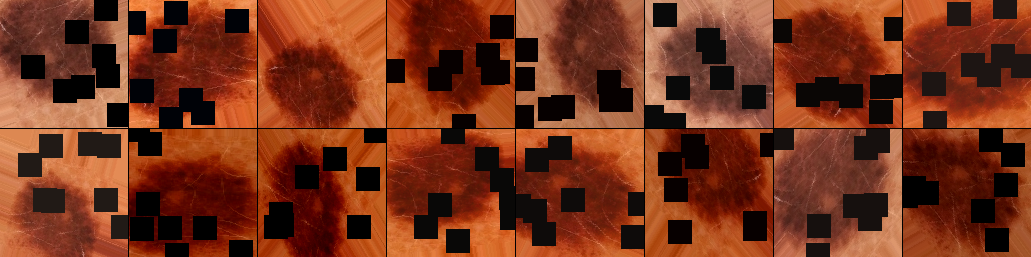

WITHOUT AUGMENTATION - Original Image


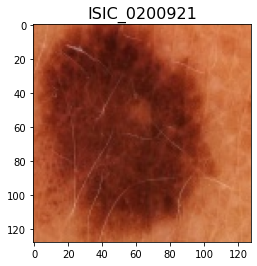

In [16]:
# DROPOUT parameters to display
RATE = 0.75; CT = 8; SIZE = 0.2

# LOAD DATA AND APPLY AUGMENTATIONS
################ DELETE IF USING COLAB PRO################
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
user_credential = user_secrets.get_gcloud_credential()
user_secrets.set_tensorflow_credential(user_credential)
from kaggle_datasets import KaggleDatasets
##########################################################
GCS_DS_PATH_tr = KaggleDatasets().get_gcs_path('freshstart128') #TRAIN PATH..ISIC20F
files_trains = tf.io.gfile.glob(GCS_DS_PATH_tr + '/isic20F*.tfrec') # train path
ds = tf.data.TFRecordDataset(files_trains, num_parallel_reads=AUTO).shuffle(1024)
ds = ds.take(1).cache().repeat()

ds = ds.map(read_unlabeled_tfrecord, num_parallel_calls=AUTO)
ds = ds.map(lambda img, target, data: (prepare_image(img, augment=True, dim=IMG_SIZES[0],
            droprate = RATE, dropct = CT, dropsize = SIZE
            ), target, data), num_parallel_calls=AUTO)
# ds = ds.map(lambda img, imgname_or_label,data: (hair_aug_tf(img),imgname_or_label,data), num_parallel_calls=AUTO)
ds = ds.take(12*5); ds = ds.prefetch(AUTO)

# DISPLAY IMAGE WITH AND WITHOUT AUGMENTATIONS
print('WITH DROPOUT AUGMENTATION - dropout_freq=%.2f count=%i size=%.3f'%(RATE,CT,SIZE))
name = show_dataset(128, 8, 2, ds)
img = cv2.imread(PATH9+name+'.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

print('WITHOUT AUGMENTATION - Original Image')
plt.title('%s'%name,size=16); plt.show()

# Step 3: Build Model
This is a common model architecute. Consider experimenting with different backbones, custom heads, losses, and optimizers. Also consider inputing meta features into your CNN.

In [17]:
EFNS = [efn.EfficientNetB0, efn.EfficientNetB1, efn.EfficientNetB2, efn.EfficientNetB3, 
        efn.EfficientNetB4, efn.EfficientNetB5, efn.EfficientNetB6]

def build_model(dim=128, ef=0):
    inp1 = tf.keras.layers.Input(shape=(dim,dim,3), name = 'inp1')
    inp2 = tf.keras.layers.Input(shape = (25), name = 'inp2')
    base = EFNS[ef](input_shape=(dim,dim,3),weights='imagenet',include_top=False)
    x = base(inp1)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
#     x1 = tf.keras.layers.Dense(1024)(inp2)
#     x1 = tf.keras.layers.Dropout(0.5)(x1)
#     x1 = tf.keras.layers.Dense(256)(inp2)
#     x1 = tf.keras.layers.Dropout(0.5)(x1)
#     x1 = tf.keras.layers.Dense(16)(x1)
#     x1 = tf.keras.layers.Activation('relu')(x1)
#     x1 = tf.keras.layers.BatchNormalization()(x1)
#     x = tf.keras.layers.concatenate([x, x1])
#     out = tf.keras.layers.Flatten()(x)
#     out = tf.keras.layers.Dense(1,activation='sigmoid')(out)
#     x = tf.keras.layers.Dense(1024, activation='relu', kernel_initializer=tf.initializers.he_normal())(x)
#     x = tf.keras.layers.Dropout(0.5)(x)
#     x = tf.keras.layers.Dense(256, activation='relu', kernel_initializer=tf.initializers.he_normal())(x)
    FC = tf.keras.layers.Dense(1, activation='sigmoid')
    fcdropouts = []
    for i in range(5):
        y = tf.keras.layers.Dropout(0.5)(x)
        y = FC(y)
        fcdropouts.append(y)

    out_pre = tf.keras.layers.Average()(fcdropouts)
#     out_binary = tf.keras.layers.Dense(1, activation='sigmoid', name='target')(out_pre)
#     out_diagnosis = tf.keras.layers.Dense(17, activation='sigmoid', name='diagnosis')(out_pre)
    
    model = tf.keras.Model(inputs=[inp1,inp2],outputs=out_pre)
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    
    
    model.compile(optimizer=opt,
                loss = 'binary_crossentropy',
                metrics=['AUC'])
    
    return model

In [18]:
build_model(IMG_SIZES[0],0).summary()

16809984/16804768 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inp1 (InputLayer)               [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
efficientnet-b0 (Model)         (None, 4, 4, 1280)   4049564     inp1[0][0]                       
__________________________________________________________________________________________________
global_average_pooling2d (Globa (None, 1280)         0           efficientnet-b0[1][0]            
__________________________________________________________________________________________________
dropout (Dropout)               (None, 1280)         0           global_average_pooling2d[0][0]   
_____________________________

# Step 4: Train Schedule
This is a common train schedule for transfer learning. The learning rate starts near zero, then increases to a maximum, then decays over time. Consider changing the schedule and/or learning rates. Note how the learning rate max is larger with larger batches sizes. This is a good practice to follow.

In [19]:
def get_lr_callback(batch_size=8):
    lr_start   = 0.000005
    lr_max     = 0.00000125 * REPLICAS * batch_size
    lr_min     = 0.000001
    lr_ramp_ep = 5
    lr_sus_ep  = 0
    lr_decay   = 0.8
   
    def lrfn(epoch):
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
            
        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max
            
        else:
            lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
            
        return lr

    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=False)
    return lr_callback

## Train Model
Our model will be trained for the number of FOLDS and EPOCHS you chose in the configuration above. Each fold the model with lowest validation loss will be saved and used to predict OOF and test. Adjust the variables `VERBOSE` and `DISPLOY_PLOT` below to determine what output you want displayed. The variable `VERBOSE=1 or 2` will display the training and validation loss and auc for each epoch as text. The variable `DISPLAY_PLOT` shows this information as a plot. 

In [20]:
predictions = []

In [21]:
# USE VERBOSE=0 for silent, VERBOSE=1 for interactive, VERBOSE=2 for commit
VERBOSE = 1
DISPLAY_PLOT = True



fold =0
EXPERIMENTS=1
    
idxT = idxTT
idxV = idxVV

# DISPLAY FOLD INFO
if DEVICE=='TPU':
    if tpu: tf.tpu.experimental.initialize_tpu_system(tpu)
print('#'*25); print('#### EXPERIMENT',fold+1)
print('#### Image Size %i with EfficientNet B%i, batch_size %i, dropout_freq=%.2f count=%i size=%.3f'%
      (IMG_SIZES[fold],EFF_NETS[fold],BATCH_SIZES[fold]*REPLICAS,
       DROP_FREQ[fold],DROP_CT[fold],DROP_SIZE[fold]))




################ DELETE IF USING COLAB PRO################
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
user_credential = user_secrets.get_gcloud_credential()
user_secrets.set_tensorflow_credential(user_credential)
from kaggle_datasets import KaggleDatasets
# CREATE TRAIN AND VALIDATION SUBSETS
GCS_DS_PATH_tr = KaggleDatasets().get_gcs_path('freshstart'+str(IMG_SIZES[0]))
##########################################################


files_train = tf.io.gfile.glob([GCS_DS_PATH_tr+'/isic20F' +str(x)+'tr*.tfrec' for x in idxT])

if INC2018[fold]:
    files_train += (tf.io.gfile.glob([GCS_DS_PATH_tr + '/isic_ext_18_'+str(x)+'tr*.tfrec'%x for x in idxT*2]))
    print('#### Using 2018+2017 external data')
for k in range(M1[fold]):
    files_train += (tf.io.gfile.glob([GCS_DS_PATH_tr + '/isic_m1_'+str(x)+'tr*.tfrec'%x for x in idxT]))
    print('#### Upsample MALIG-1 data (2020 comp)')
for k in range(M2[fold]):
    files_train += (tf.io.gfile.glob([GCS_DS_PATH_tr + '/isic_m2_'+str(x)+'tr*.tfrec'%x for x in idxT+15]))
    print('#### Upsample MALIG-2 data (ISIC website)')
for k in range(M3[fold]):
    files_train += (tf.io.gfile.glob([GCS_DS_PATH_tr + '/isic_m3_'+str(x)+'tr*.tfrec'%x for x in idxT*2+1+30]))
    print('#### Upsample MALIG-3 data (2019 comp)')
for k in range(M4[fold]):
    files_train += (tf.io.gfile.glob([GCS_DS_PATH_tr + '/isic_m4_'+str(x)+'tr*.tfrec'%x for x in idxT*2+30]))
    print('#### Upsample MALIG-4 data (2018 2017 comp)')


np.random.shuffle(files_train); print('#'*25)

files_valid = (tf.io.gfile.glob([GCS_DS_PATH_tr + '/isic20F'+str(x)+'tr*.tfrec' for x in idxV]))
files_test  = (tf.io.gfile.glob(GCS_DS_PATH_tr + '/isic20test*.tfrec'))

# BUILD MODEL
K.clear_session()
with strategy.scope():
    model = build_model(dim=IMG_SIZES[fold],ef=EFF_NETS[fold])



# SAVE BEST MODEL EACH FOLD
sv_auc = tf.keras.callbacks.ModelCheckpoint(
    'b'+str(EFF_NETS[fold])+'_'+str(IMG_SIZES[fold])+'_auc_f'+str(FNUMBER-1)+'.h5',
    monitor='val_auc', verbose=0, save_best_only=True,
    save_weights_only=True, mode='max', save_freq='epoch')

sv_loss = tf.keras.callbacks.ModelCheckpoint(
    'b'+str(EFF_NETS[fold])+'_'+str(IMG_SIZES[fold])+'_loss_f'+str(FNUMBER-1)+'.h5',
    monitor='val_loss', verbose=0, save_best_only=True,
    save_weights_only=True, mode='min', save_freq='epoch')


# TRAIN
print('Training...')
history = model.fit(
    get_dataset(files_train, augment=True, shuffle=True, repeat=True,
            dim=IMG_SIZES[fold], batch_size = BATCH_SIZES[fold],
            droprate=DROP_FREQ[fold], dropct=DROP_CT[fold], dropsize=DROP_SIZE[fold]), 
    epochs=EPOCHS[fold], callbacks = [sv_auc,sv_loss,get_lr_callback(BATCH_SIZES[fold])], 
    steps_per_epoch=count_data_items(files_train)/BATCH_SIZES[fold]//REPLICAS,
    validation_data=get_dataset(files_valid,augment=False,shuffle=False,
            repeat=False,dim=IMG_SIZES[fold]), class_weight = {0:CW[fold][0],1:CW[fold][1]}
    ,verbose=VERBOSE)

  
        
        
        
    

#########################
#### EXPERIMENT 1
#### Image Size 128 with EfficientNet B6, batch_size 32, dropout_freq=0.70 count=7 size=0.140
#### Using 2018+2017 external data
#### Upsample MALIG-1 data (2020 comp)
#### Upsample MALIG-1 data (2020 comp)
#### Upsample MALIG-1 data (2020 comp)
#### Upsample MALIG-1 data (2020 comp)
#### Upsample MALIG-1 data (2020 comp)
#### Upsample MALIG-1 data (2020 comp)
#### Upsample MALIG-1 data (2020 comp)
#### Upsample MALIG-1 data (2020 comp)
#### Upsample MALIG-1 data (2020 comp)
#### Upsample MALIG-1 data (2020 comp)
#### Upsample MALIG-1 data (2020 comp)
#### Upsample MALIG-1 data (2020 comp)
#### Upsample MALIG-1 data (2020 comp)
#### Upsample MALIG-1 data (2020 comp)
#### Upsample MALIG-1 data (2020 comp)
#### Upsample MALIG-1 data (2020 comp)
#### Upsample MALIG-1 data (2020 comp)
#### Upsample MALIG-1 data (2020 comp)
#### Upsample MALIG-1 data (2020 comp)
#### Upsample MALIG-1 data (2020 comp)
#### Upsample MALIG-1 data (2020 comp)
#### Ups

In [22]:
print('Loading best models...')
models = ['b'+str(EFF_NETS[fold])+'_'+str(IMG_SIZES[fold])+'_loss_f'+str(FNUMBER-1)+'.h5',
          'b'+str(EFF_NETS[fold])+'_'+str(IMG_SIZES[fold])+'_auc_f'+str(FNUMBER-1)+'.h5']


for model_idx, model_path in enumerate(models):
    model.load_weights(model_path)
    if model_idx==0:

        print('##########b'+str(EFF_NETS[fold])+'_'+str(IMG_SIZES[fold])+'_loss_f'+str(FNUMBER-1)+'.h5###########')
    else:
        print('##########b'+str(EFF_NETS[fold])+'_'+str(IMG_SIZES[fold])+'_auc_f'+str(FNUMBER-1)+'.h5###########')
    oof_pred = []; oof_tar = []; oof_val = []; oof_names = []; oof_folds = [] 
    preds = np.zeros((count_data_items(files_test),1))
    # PREDICT OOF USING TTA
    print('Predicting OOF with TTA...')
    ds_valid = get_dataset(files_valid,labeled=False,return_image_names=False,augment=True,
            repeat=True,shuffle=False,dim=IMG_SIZES[fold],batch_size=BATCH_SIZES[fold]*2,
            droprate=DROP_FREQ[fold], dropct=DROP_CT[fold], dropsize=DROP_SIZE[fold])
    ct_valid = count_data_items(files_valid); STEPS = TTA * ct_valid/BATCH_SIZES[fold]/2/REPLICAS
    pred = model.predict(ds_valid,steps=STEPS,verbose=VERBOSE)[:TTA*ct_valid,] 
    oof_pred.append( np.mean(pred.reshape((ct_valid,TTA),order='F'),axis=1) )

    # GET OOF TARGETS AND NAMES
    ds_valid = get_dataset(files_valid, augment=False, repeat=False, dim=IMG_SIZES[fold],
            labeled=True, return_image_names=True)
    oof_tar.append( np.array([target.numpy() for img, target in iter(ds_valid.unbatch())]) )
    oof_folds.append( np.ones_like(oof_tar[-1],dtype='int8')*fold )
    ds = get_dataset(files_valid, augment=False, repeat=False, dim=IMG_SIZES[fold],
                labeled=False, return_image_names=True)
    oof_names.append( np.array([img_name.numpy().decode("utf-8") for img, img_name in iter(ds.unbatch())]))

    # PREDICT TEST USING TTA
    print('Predicting Test with TTA...')
    ds_test = get_dataset(files_test,labeled=False,return_image_names=False,augment=True,
            repeat=True,shuffle=False,dim=IMG_SIZES[fold],batch_size=BATCH_SIZES[fold]*4)
    ct_test = count_data_items(files_test); STEPS = TTA * ct_test/BATCH_SIZES[fold]/4/REPLICAS
    pred = model.predict(ds_test,steps=STEPS,verbose=VERBOSE)[:TTA*ct_test,] 
    preds[:,0] += np.mean(pred.reshape((ct_test,TTA),order='F'),axis=1) * WGTS[fold]
    predictions.append(preds)
    # REPORT RESULTS
    auc = roc_auc_score(oof_tar[-1],oof_pred[-1])
    oof_val.append(np.max( history.history['val_auc'] ))
    print('#### FOLD %i OOF AUC without TTA = %.3f, with TTA = %.3f'%(fold+1,oof_val[-1],auc))



            # COMPUTE OVERALL OOF AUC
    oof = np.concatenate(oof_pred); true = np.concatenate(oof_tar);
    names = np.concatenate(oof_names); folds = np.concatenate(oof_folds)
    auc = roc_auc_score(true,oof)
    print('Overall OOF AUC with TTA = %.3f'%auc)

    # SAVE OOF TO DISK
    df_oof = pd.DataFrame(dict(
        image_name = names, target=true, pred = oof, fold=folds))
    if model_idx==0:
        df_oof.to_csv('oof_'+str(EFF_NETS[fold])+'_'+str(IMG_SIZES[fold])+'_loss_f'+str(FNUMBER-1)+'.csv',index=False)
    else:
        df_oof.to_csv('oof_'+str(EFF_NETS[fold])+'_'+str(IMG_SIZES[fold])+'_auc_f'+str(FNUMBER-1)+'.csv',index=False)
    df_oof.head()


#         if model_idx==0:
#             preds_loss = preds
#         else:
#             preds_auc = preds



Loading best models...
##########b6_128_loss_f1.h5###########
Predicting OOF with TTA...
1124/1123 [==============================] - 52s 46ms/step
Predicting Test with TTA...
944/943 [==============================] - 47s 49ms/step
#### FOLD 1 OOF AUC without TTA = 0.855, with TTA = 0.855
Overall OOF AUC with TTA = 0.855
##########b6_128_auc_f1.h5###########
Predicting OOF with TTA...
1124/1123 [==============================] - 51s 45ms/step
Predicting Test with TTA...
944/943 [==============================] - 47s 49ms/step
#### FOLD 1 OOF AUC without TTA = 0.855, with TTA = 0.876
Overall OOF AUC with TTA = 0.876


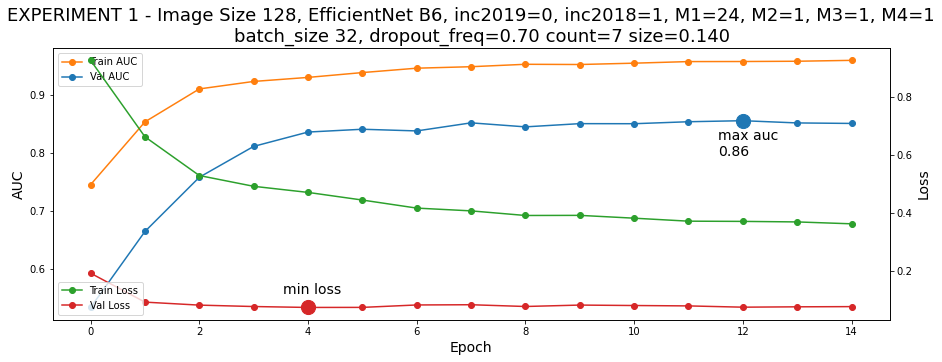

In [23]:
if DISPLAY_PLOT:
    plt.figure(figsize=(15,5))
    plt.plot(np.arange(EPOCHS[fold]),history.history['auc'],'-o',label='Train AUC',color='#ff7f0e')
    plt.plot(np.arange(EPOCHS[fold]),history.history['val_auc'],'-o',label='Val AUC',color='#1f77b4')
    x = np.argmax( history.history['val_auc'] ); y = np.max( history.history['val_auc'] )
    xdist = plt.xlim()[1] - plt.xlim()[0]; ydist = plt.ylim()[1] - plt.ylim()[0]
    plt.scatter(x,y,s=200,color='#1f77b4'); plt.text(x-0.03*xdist,y-0.13*ydist,'max auc\n%.2f'%y,size=14)
    plt.ylabel('AUC',size=14); plt.xlabel('Epoch',size=14)
    plt.legend(loc=2)
    plt2 = plt.gca().twinx()
    plt2.plot(np.arange(EPOCHS[fold]),history.history['loss'],'-o',label='Train Loss',color='#2ca02c')
    plt2.plot(np.arange(EPOCHS[fold]),history.history['val_loss'],'-o',label='Val Loss',color='#d62728')
    x = np.argmin( history.history['val_loss'] ); y = np.min( history.history['val_loss'] )
    ydist = plt.ylim()[1] - plt.ylim()[0]
    plt.scatter(x,y,s=200,color='#d62728'); plt.text(x-0.03*xdist,y+0.05*ydist,'min loss',size=14)
    plt.ylabel('Loss',size=14)
    plt.title('EXPERIMENT %i - Image Size %i, EfficientNet B%i, inc2019=%i, inc2018=%i, M1=%i, M2=%i, M3=%i, M4=%i\n\
    batch_size %i, dropout_freq=%.2f count=%i size=%.3f'%
            (fold+1,IMG_SIZES[fold],EFF_NETS[fold],INC2019[fold],INC2018[fold],M1[fold],M2[fold],M3[fold],
             M4[fold],BATCH_SIZES[fold]*REPLICAS,DROP_FREQ[fold],DROP_CT[fold],DROP_SIZE[fold]),size=18)
    plt.legend(loc=3)
    plt.show()

## Calculate OOF AUC
The OOF (out of fold) predictions are saved to disk. If you wish to ensemble multiple models, use the OOF to determine what are the best weights to blend your models with. Choose weights that maximize OOF CV score when used to blend OOF. Then use those same weights to blend your test predictions.

In [24]:
# # COMPUTE OVERALL OOF AUC
# oof = np.concatenate(oof_pred); true = np.concatenate(oof_tar);
# names = np.concatenate(oof_names); folds = np.concatenate(oof_folds)
# auc = roc_auc_score(true,oof)
# print('Overall OOF AUC with TTA = %.3f'%auc)

# # SAVE OOF TO DISK
# df_oof = pd.DataFrame(dict(
#     image_name = names, target=true, pred = oof, fold=folds))
# df_oof.to_csv('oof.csv',index=False)
# df_oof.head()

# Step 5: Post process
There are ways to modify predictions based on patient information to increase CV LB. You can experiment with that here on your OOF.

# Submit To Kaggle

In [25]:
ds = get_dataset(files_test, augment=False, repeat=False, dim=IMG_SIZES[fold],
                 labeled=False, return_image_names=True)

image_names = np.array([img_name.numpy().decode("utf-8") 
                        for img, img_name in iter(ds.unbatch())])

In [26]:
submission = pd.DataFrame(dict(image_name=image_names, target=predictions[0][:,0]))
submission = submission.sort_values('image_name') 
submission.to_csv(str(EFF_NETS[fold])+'_'+str(IMG_SIZES[fold])+'_loss_f'+str(FNUMBER-1)+'_submission.csv', index=False)
submission.head()

,image_name,target
4956,ISIC_0052060,0.005797
6220,ISIC_0052349,0.005759
1560,ISIC_0058510,0.001975
6921,ISIC_0073313,0.001665
7233,ISIC_0073502,0.009552


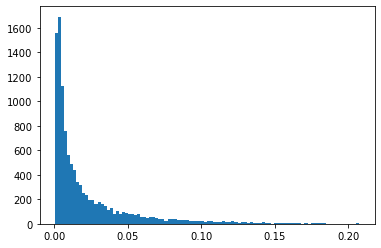

In [27]:
plt.hist(submission.target,bins=100)
plt.show()

In [28]:
submission = pd.DataFrame(dict(image_name=image_names, target=predictions[1][:,0]))
submission = submission.sort_values('image_name') 
submission.to_csv(str(EFF_NETS[fold])+'_'+str(IMG_SIZES[fold])+'_auc_f'+str(FNUMBER-1)+'_submission.csv', index=False)
submission.head()

,image_name,target
4956,ISIC_0052060,0.000662
6220,ISIC_0052349,0.000284
1560,ISIC_0058510,0.000109
6921,ISIC_0073313,0.001088
7233,ISIC_0073502,0.005303


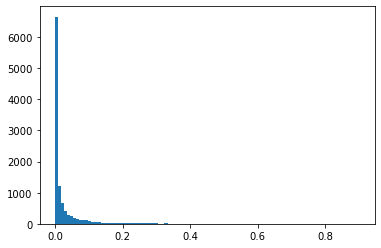

In [29]:
plt.hist(submission.target,bins=100)
plt.show()